# Task 2: Covid Rumour Analysis

## Read in the data

In [1]:
import os
import json
import re

def read_data(file_name):
    rumours = []
    non_rumours = []
    with open("data/" + file_name +".data.txt", "r") as f:
        raw_data = [line.rstrip().split(',')[0] for line in f.readlines()]
    with open("data/" + file_name +".label.txt", "r") as f:
        raw_label = f.readlines()
    existing_data = []
    for data in raw_data:
        path = "data/" + file_name +'/' + data + ".json"
        if os.path.exists(path):
            existing_data.append(data)
    if file_name == "covid":
        empty_data = [2545, 3585, 4649, 8890, 9396, 12562, 15123, 15887]
        for elements in sorted(empty_data, reverse=True):
            existing_data.pop(elements)
    print("raw_data: ", len(raw_data))
    print("existing_data: ", len(existing_data))
    print("raw_label: ", len(raw_label))
    for data, label in zip(existing_data, raw_label):
        label = label.strip()
        path = "data/" + file_name +'/' + data + ".json"
        if os.path.exists(path):
            tweet = json.load(open(path, "r"))
            if label == "rumour":
                rumours.append(twitter_feature_selection(tweet))
            elif label == "nonrumour":
                non_rumours.append(twitter_feature_selection(tweet))
    return rumours, non_rumours

def twitter_feature_selection(json_file):
    selected_feature = {
        "text": json_file["text"],
        "id": json_file["id"],
        "created_at": json_file["created_at"],
        "retweet_count": json_file["public_metrics"]["retweet_count"],
        "reply_count": json_file["public_metrics"]["reply_count"],
        "like_count": json_file["public_metrics"]["like_count"],
        "quote_count": json_file["public_metrics"]["quote_count"],
        "hashtag": re.findall(r"#\w+", json_file["text"])}
    return selected_feature

rumour_list, non_rumour_list = read_data("covid")

raw_data:  17458
existing_data:  15955
raw_label:  15955


## 1. Rumour Distribution

/var/folders/yy/3xdbk_rd7zjcs4y3m259qjt00000gn/T/ipykernel_24143/4283761201.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


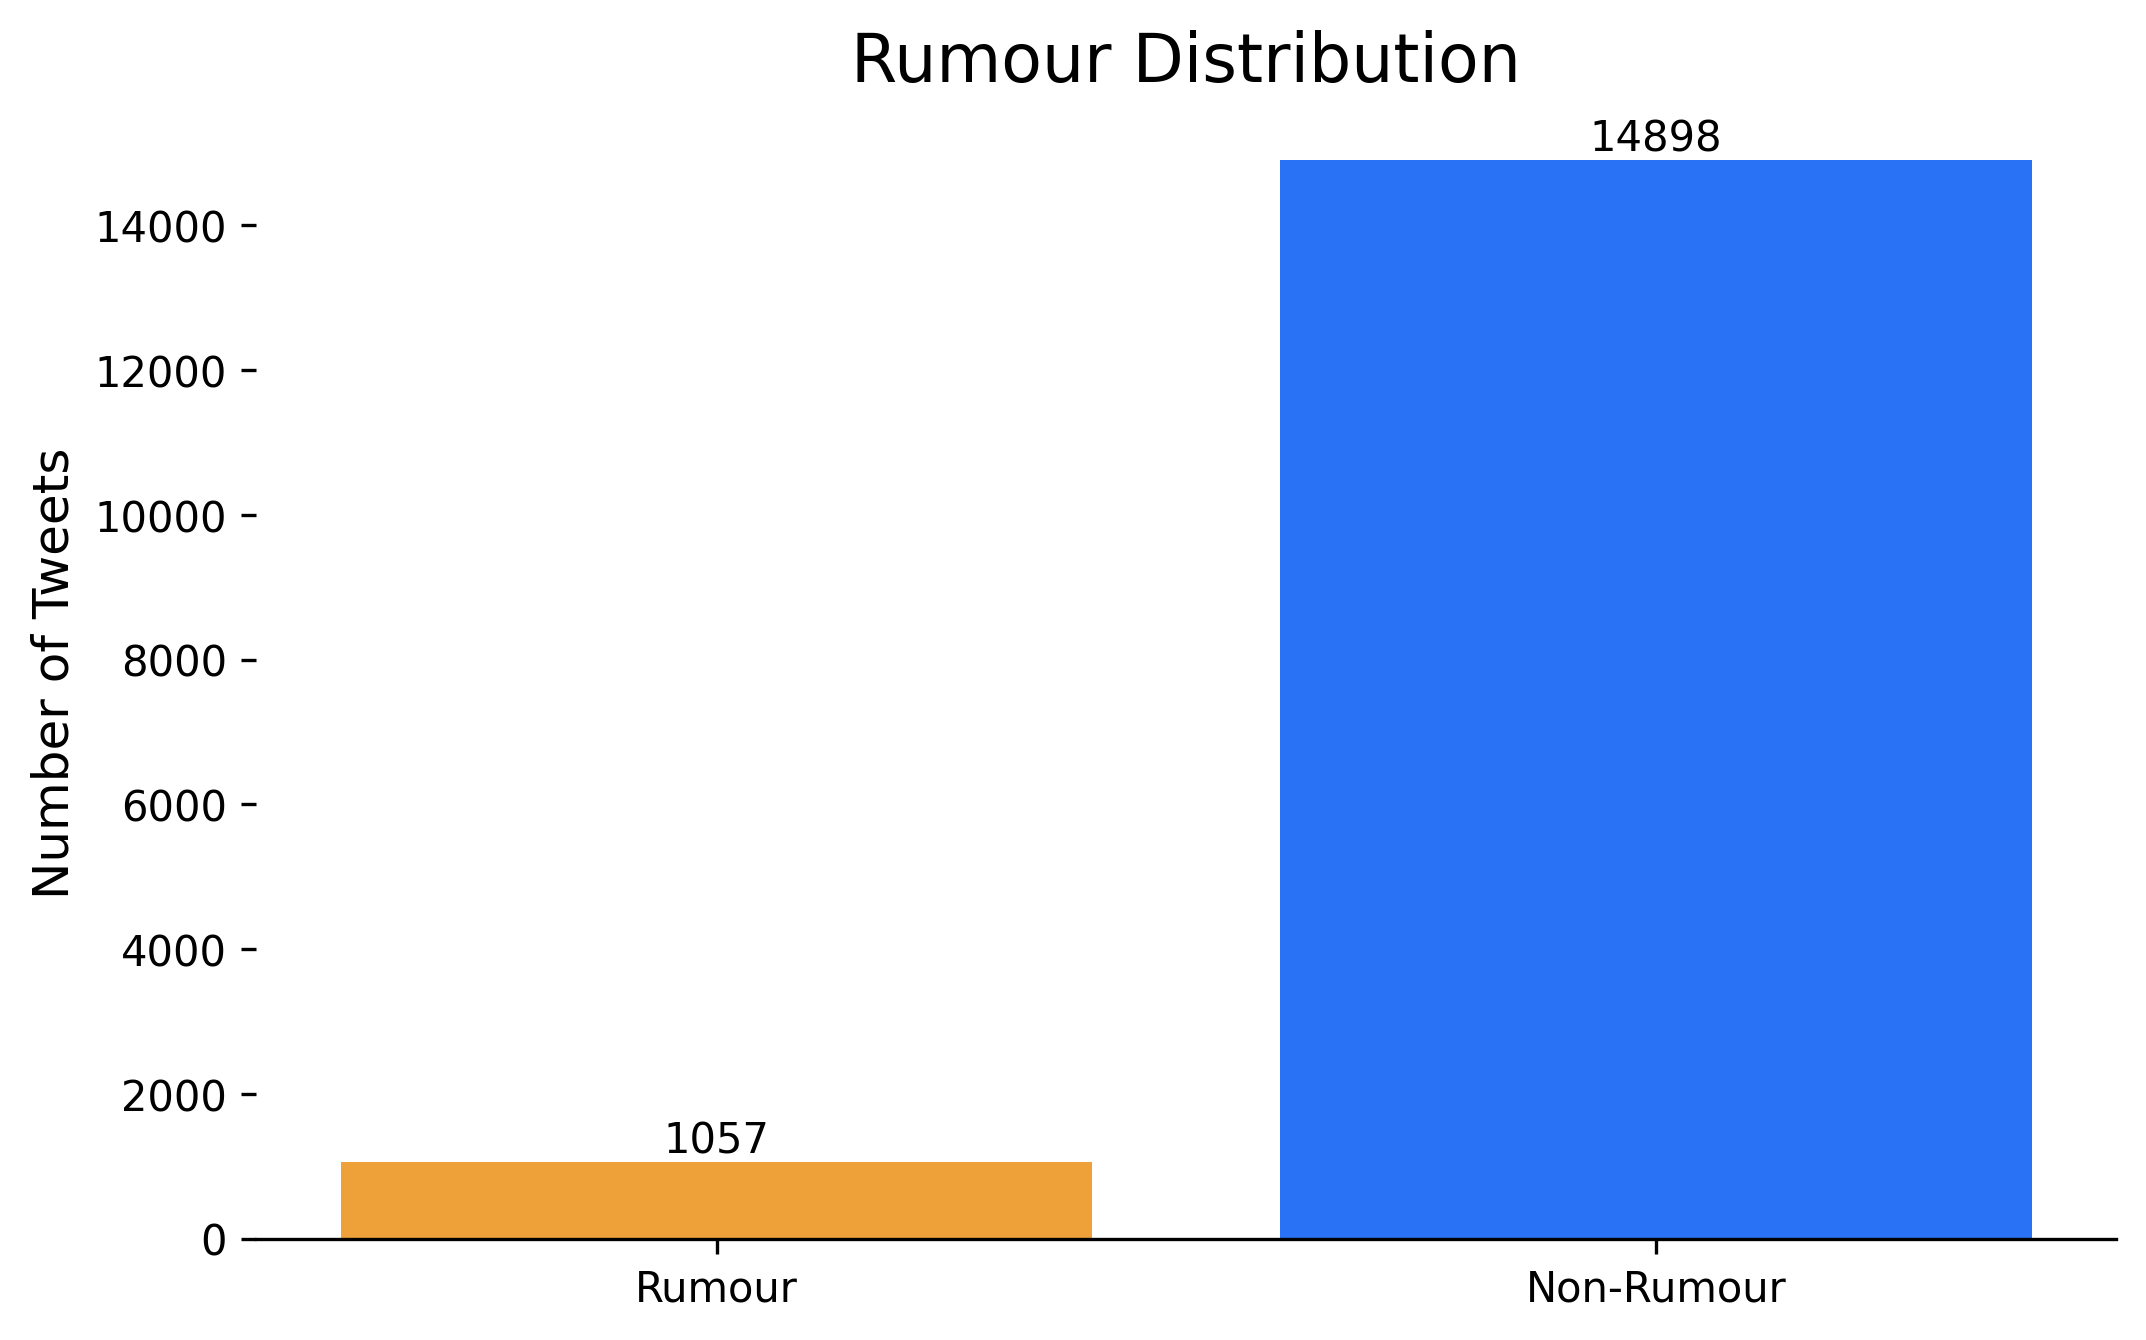

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_rumour_distribution():
    x_data = ["Rumour", "Non-Rumour"]
    y_data = [len(rumour_list), len(non_rumour_list)]

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    ax.bar(x_data, y_data, color=["#EEA039", "#2972F6"])
    ax.set_title("Rumour Distribution", fontsize=16)
    ax.set_ylabel("Number of Tweets", fontsize=12)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    for x, y in zip(x_data, y_data):
        ax.text(x, y, y, ha='center', va='bottom')
    fig.show()

plot_rumour_distribution()

/var/folders/yy/3xdbk_rd7zjcs4y3m259qjt00000gn/T/ipykernel_24143/1339734705.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


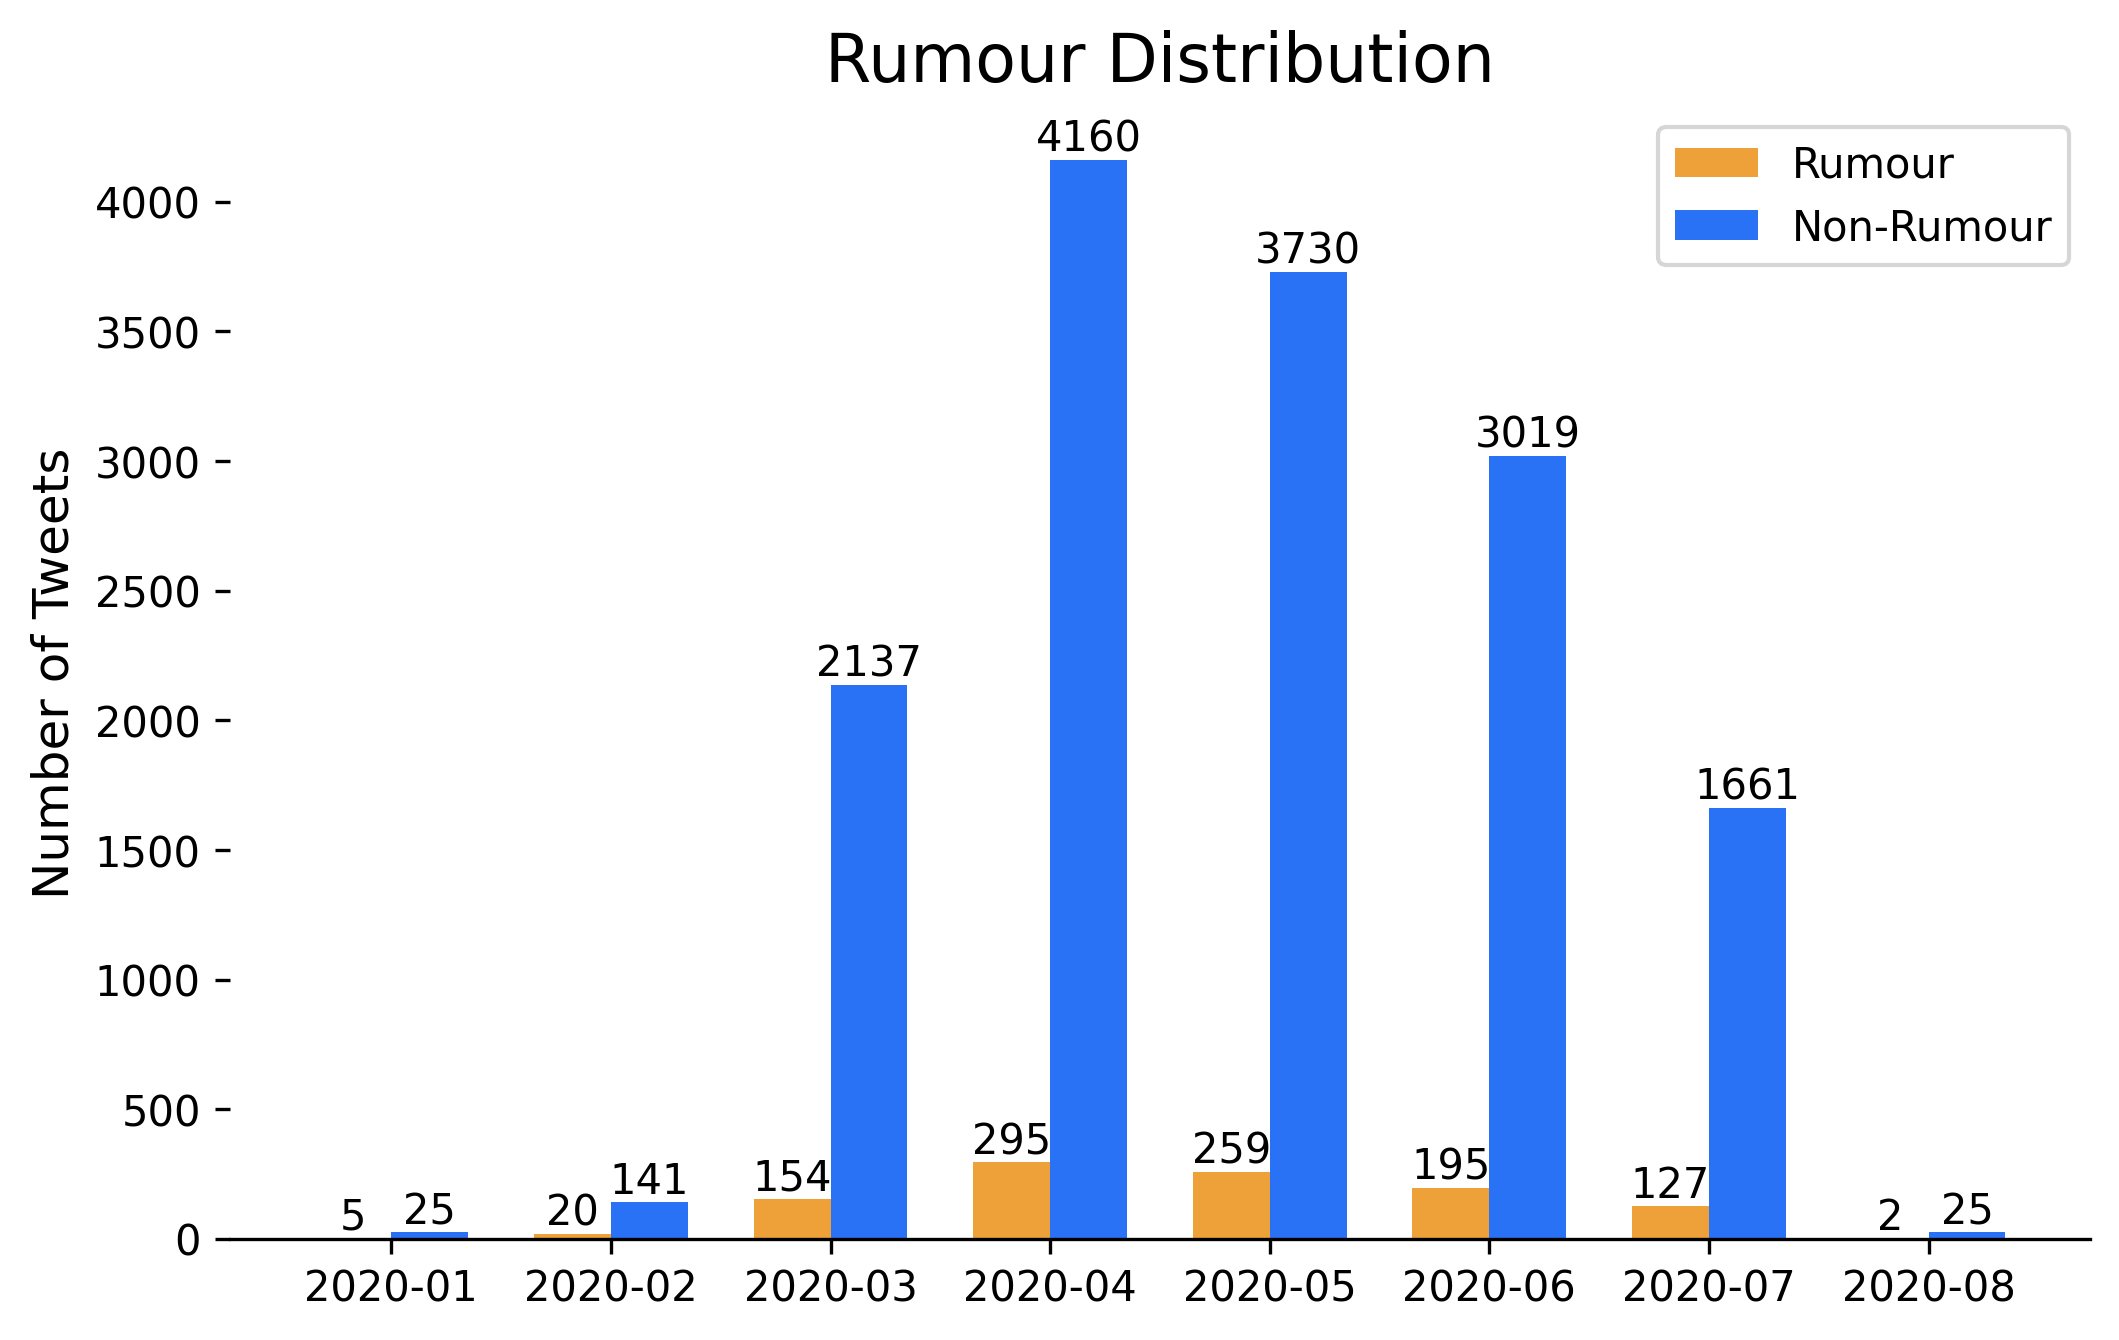

In [3]:
import numpy as np

# analyse how rumour topics or trends evolve over time
rumour_list_by_date = {}
for tweet in rumour_list:
    date = tweet["created_at"].split(' ')[0][:7]
    if date in rumour_list_by_date:
        rumour_list_by_date[date] += 1
    else:
        rumour_list_by_date[date] = 1

non_rumour_list_by_date = {}
for tweet in non_rumour_list:
    date = tweet["created_at"].split(' ')[0][:7]
    if date in non_rumour_list_by_date:
        non_rumour_list_by_date[date] += 1
    else:
        non_rumour_list_by_date[date] = 1

def plot_rumour_distribution():
    # plot the monthly distribution of rumours and non rumours in grouped bar chart
    labels = list(sorted(rumour_list_by_date.keys()))
    rumours_count = [rumour_list_by_date[label] for label in labels]
    non_rumours_count = [non_rumour_list_by_date[label] for label in labels]
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    rumours_bar = ax.bar(x - width/2, rumours_count, width, label="Rumour", color="#EEA039")
    non_rumours_bar = ax.bar(x + width/2, non_rumours_count, width, label="Non-Rumour", color="#2972F6")
    ax.set_title("Rumour Distribution", fontsize=16)
    ax.set_ylabel("Number of Tweets", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    ax.bar_label(rumours_bar, rumours_count, fontsize=10)
    ax.bar_label(non_rumours_bar, non_rumours_count, fontsize=10)
    fig.show()


plot_rumour_distribution()

## 2. Topic Modeling

/Users/z/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/z/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


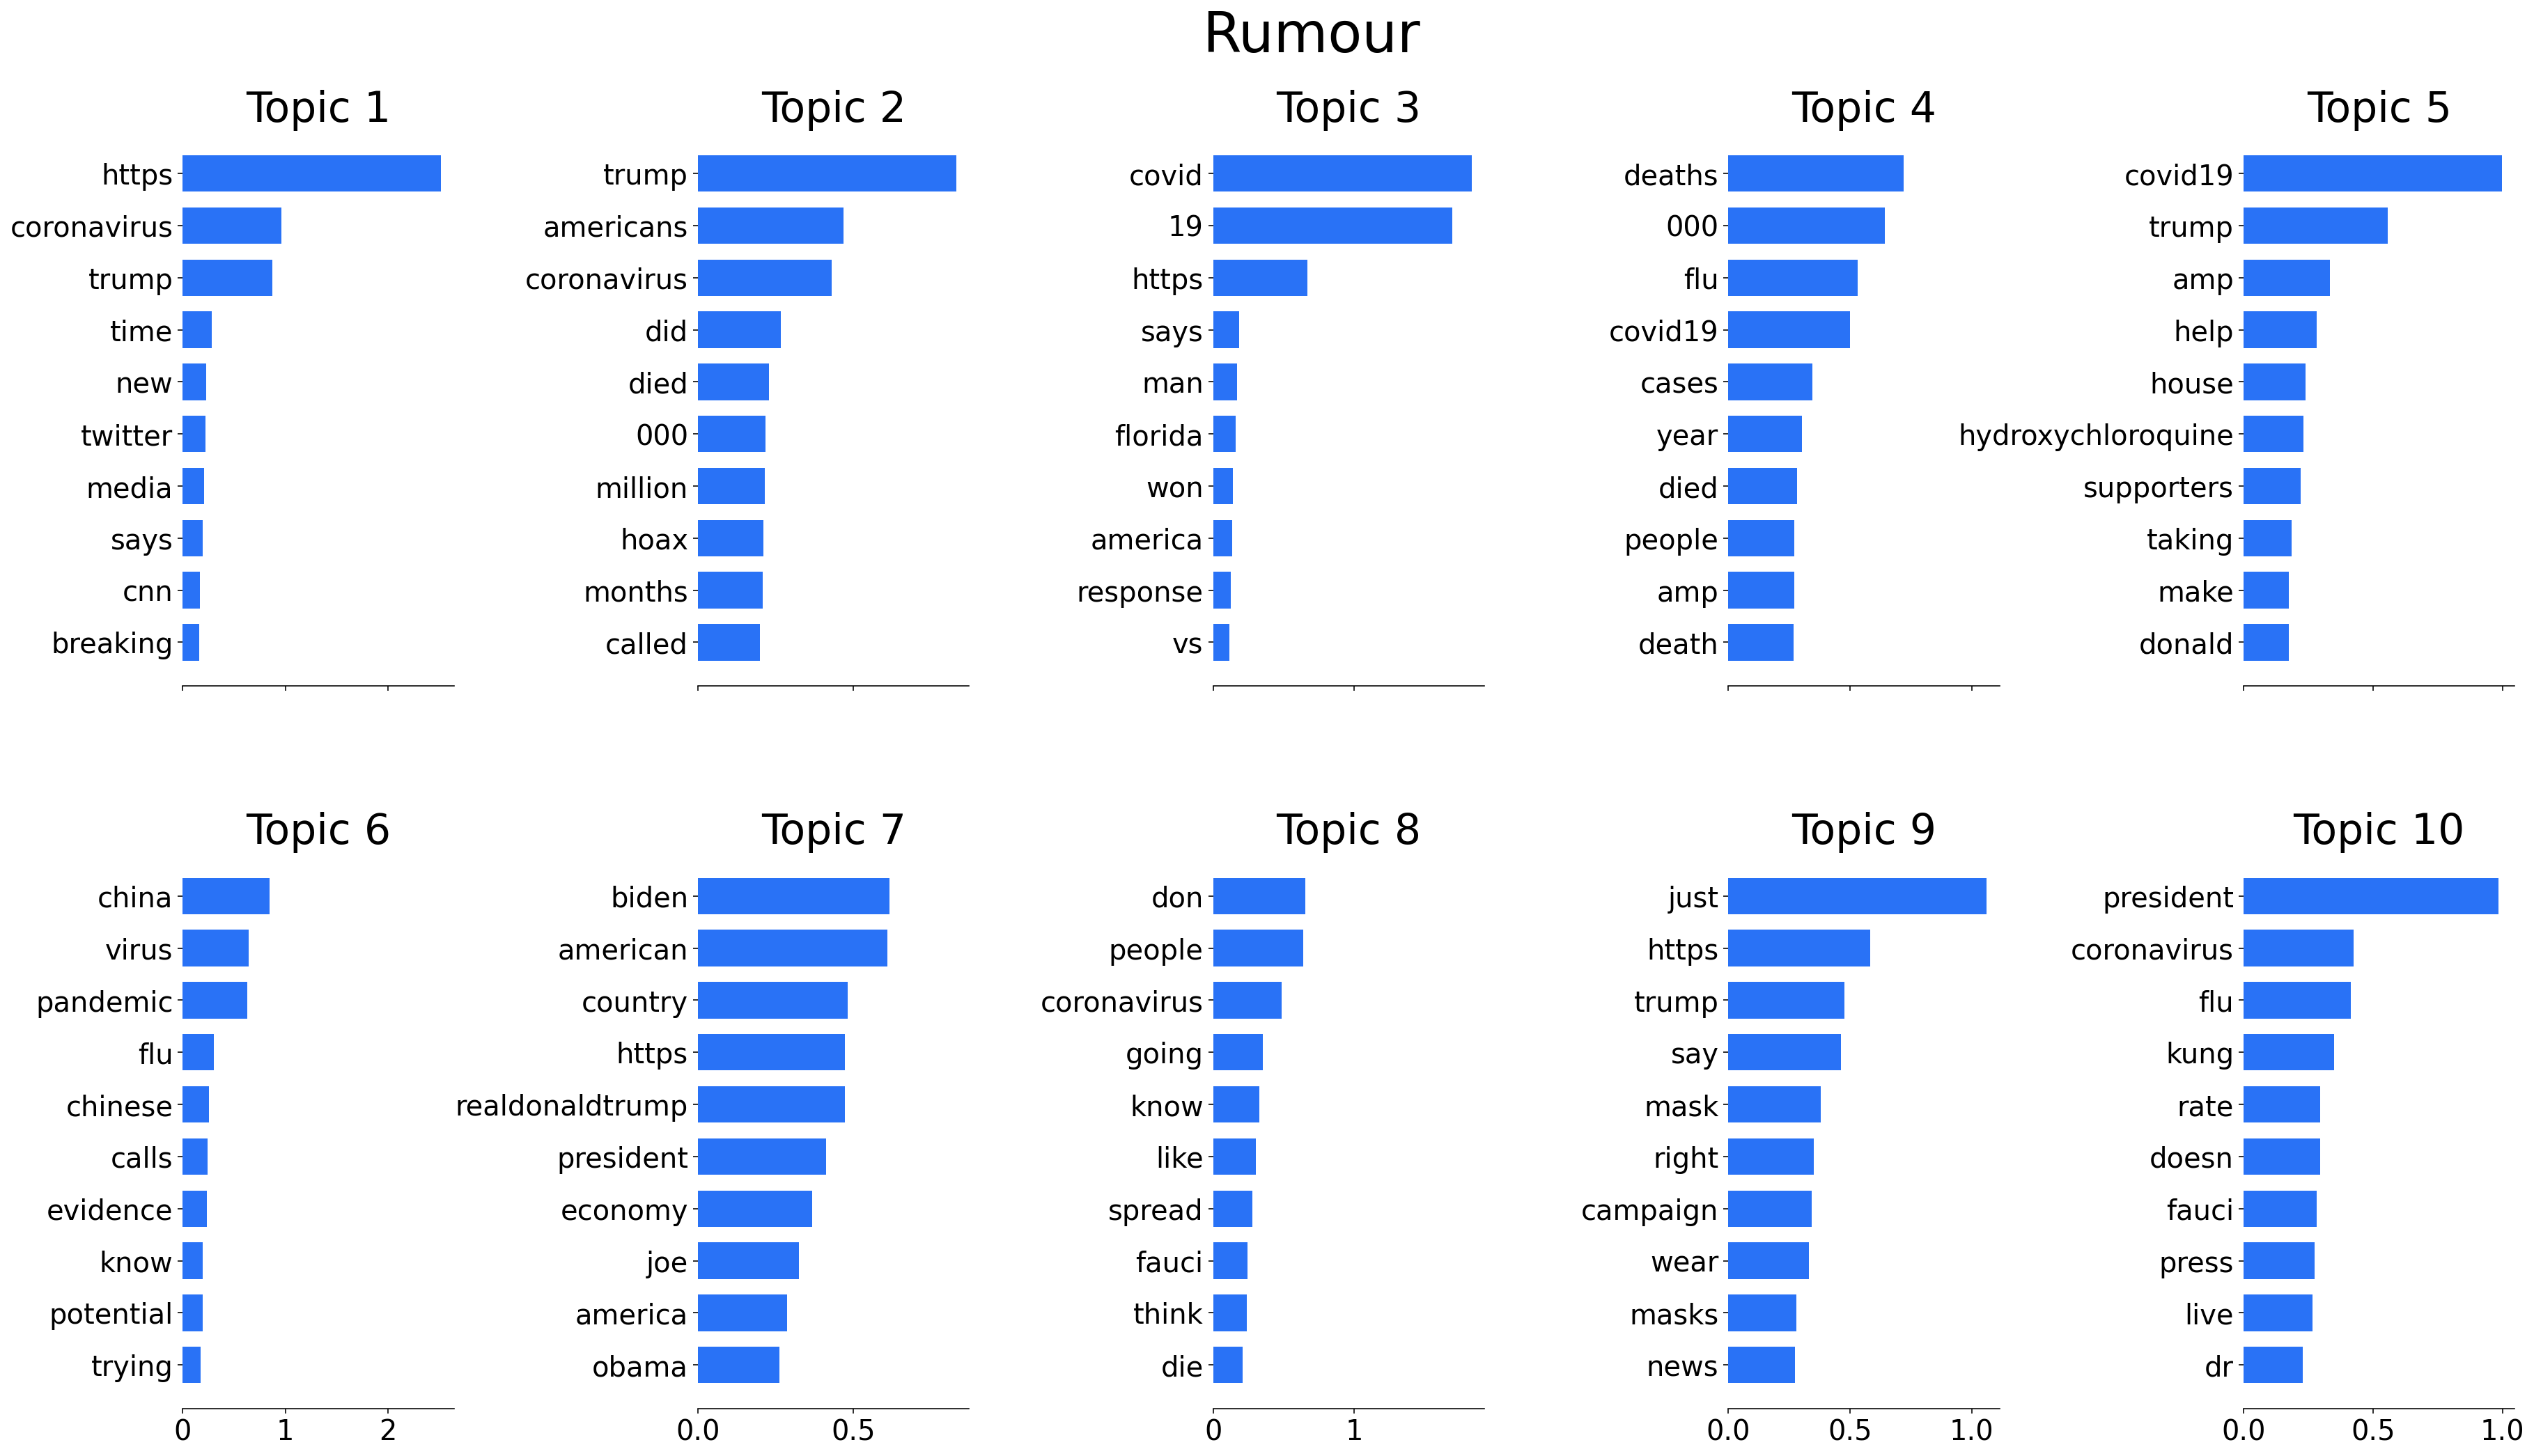

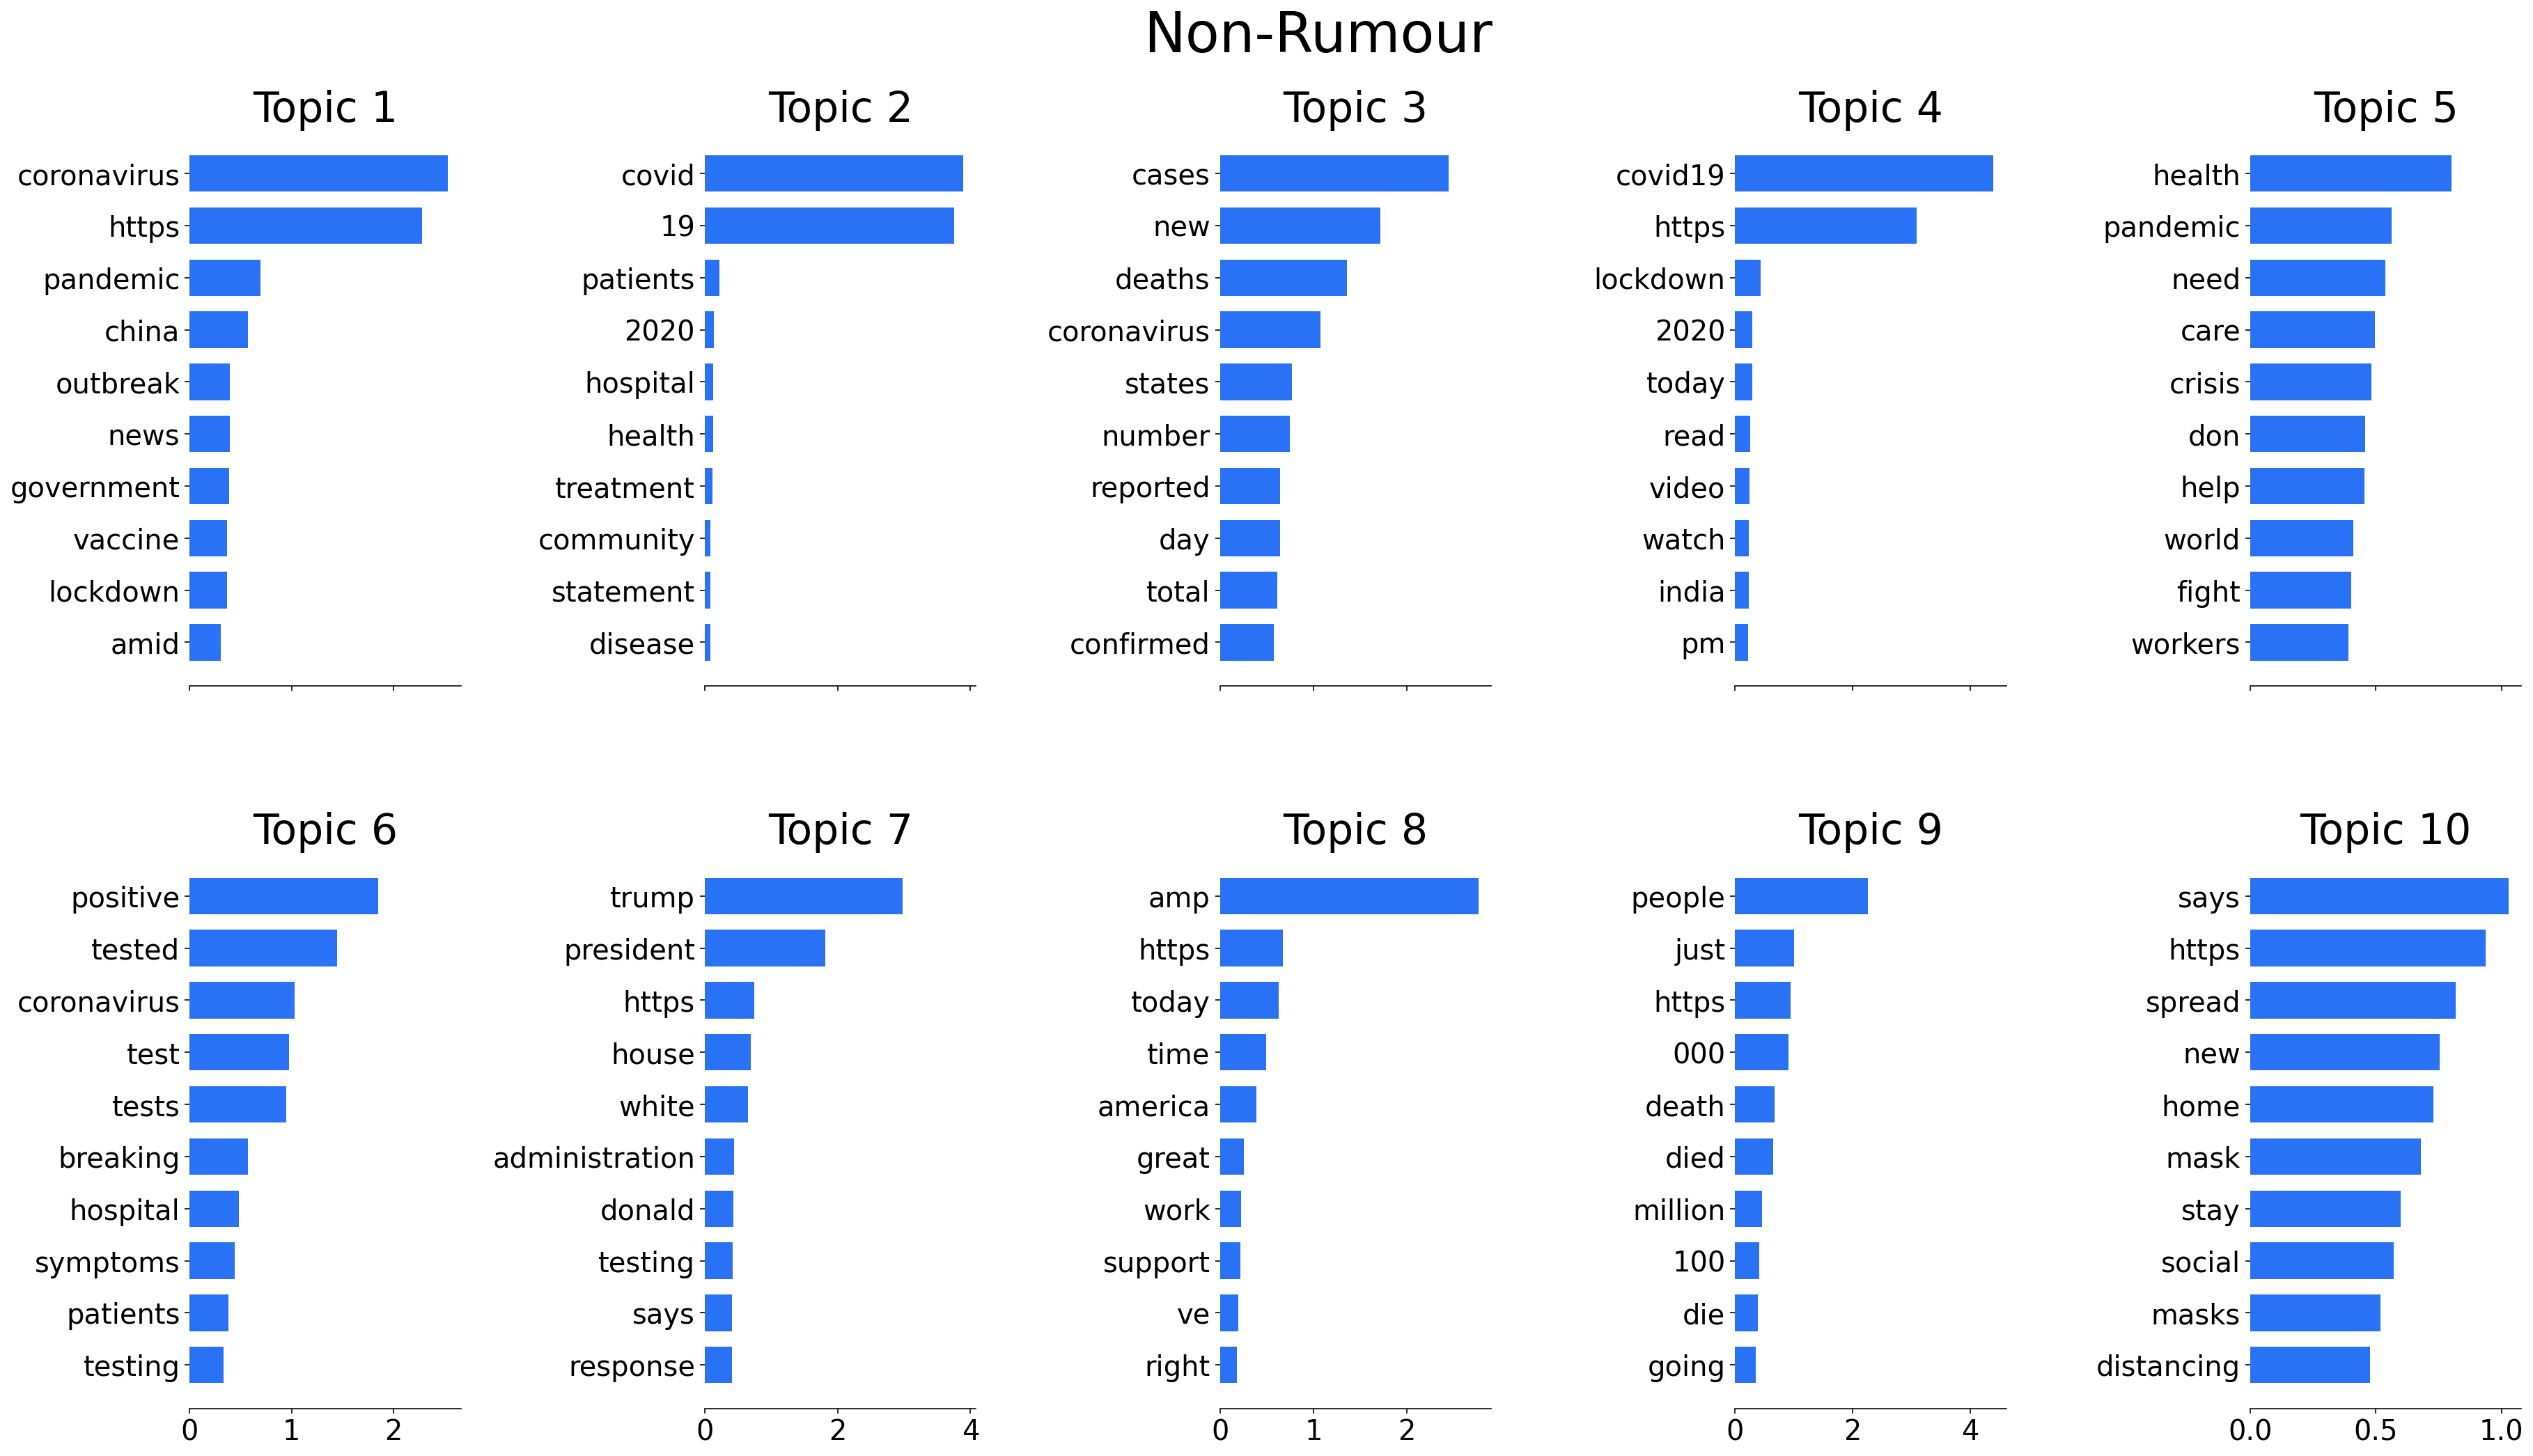

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
# modified from
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

n_features = 1000
n_components = 10
n_top_words = 10

rumour_text = [lines["text"] for lines in rumour_list]
non_rumour_text = [lines["text"] for lines in non_rumour_list]

def plot_top_words(model, feature_names, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), dpi=144, sharex="col")
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color="#2972F6")
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Use tf-idf features for NMF
rumour_tfidf_vec = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
non_rumour_tfidf_vec = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english")

rumour_tfidf = rumour_tfidf_vec.fit_transform(rumour_text)
non_rumour_tfidf = non_rumour_tfidf_vec.fit_transform(non_rumour_text)

# Fit the NMF model (generalized Kullback-Leibler divergence)
rumour_nmf_model = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5).fit(rumour_tfidf)
non_rumour_nmf_model = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5).fit(non_rumour_tfidf)

rumour_tfidf_feature_names = rumour_tfidf_vec.get_feature_names_out()
non_rumour_tfidf_feature_names = non_rumour_tfidf_vec.get_feature_names_out()

plot_top_words(rumour_nmf_model, rumour_tfidf_feature_names, "Rumour")
plot_top_words(non_rumour_nmf_model, non_rumour_tfidf_feature_names, "Non-Rumour")

# # Use tf (raw term count) features for LDA.
# rumour_tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
# non_rumour_tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
#
# rumour_tf = rumour_tf_vectorizer.fit_transform(rumour_text)
# non_rumour_tf = non_rumour_tf_vectorizer.fit_transform(non_rumour_text)
#
# # Fit the LDA model
# rumour_lda = LatentDirichletAllocation(
#     n_components=n_components,
#     max_iter=5,
#     learning_method="online",
#     learning_offset=50.0,
#     random_state=0).fit(rumour_tf)
#
# non_rumour_lda = LatentDirichletAllocation(
#     n_components=n_components,
#     max_iter=5,
#     learning_method="online",
#     learning_offset=50.0,
#     random_state=0).fit(non_rumour_tf)
#
# rumour_tf_feature_names = rumour_tf_vectorizer.get_feature_names_out()
# non_rumour_tf_feature_names = non_rumour_tf_vectorizer.get_feature_names_out()

# plot_top_words(rumour_lda, rumour_tf_feature_names, "Rumour LDA")
# plot_top_words(non_rumour_lda, non_rumour_tf_feature_names, "Non-Rumour LDA")

## 3. Most Common Words

In [13]:
import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
word_tokenizer = TweetTokenizer()
stop_words = stopwords.words('english')

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

def count_common_words(text):
    common_words = {}
    for tweet in text:
        tokenized_tweet = word_tokenizer.tokenize(tweet)
        for word in tokenized_tweet:
            word = word.lower()
            if word not in stop_words and word.isalpha():
                word = lemmatize(word)
                if word in common_words:
                    common_words[word] += 1
                else:
                    common_words[word] = 1
    sorted_common_words = sorted(common_words.items(), key=lambda x: x[1], reverse=True)[:10]
    return sorted_common_words

rumour_text_rank = count_common_words(rumour_text)
non_rumour_text_rank = count_common_words(non_rumour_text)

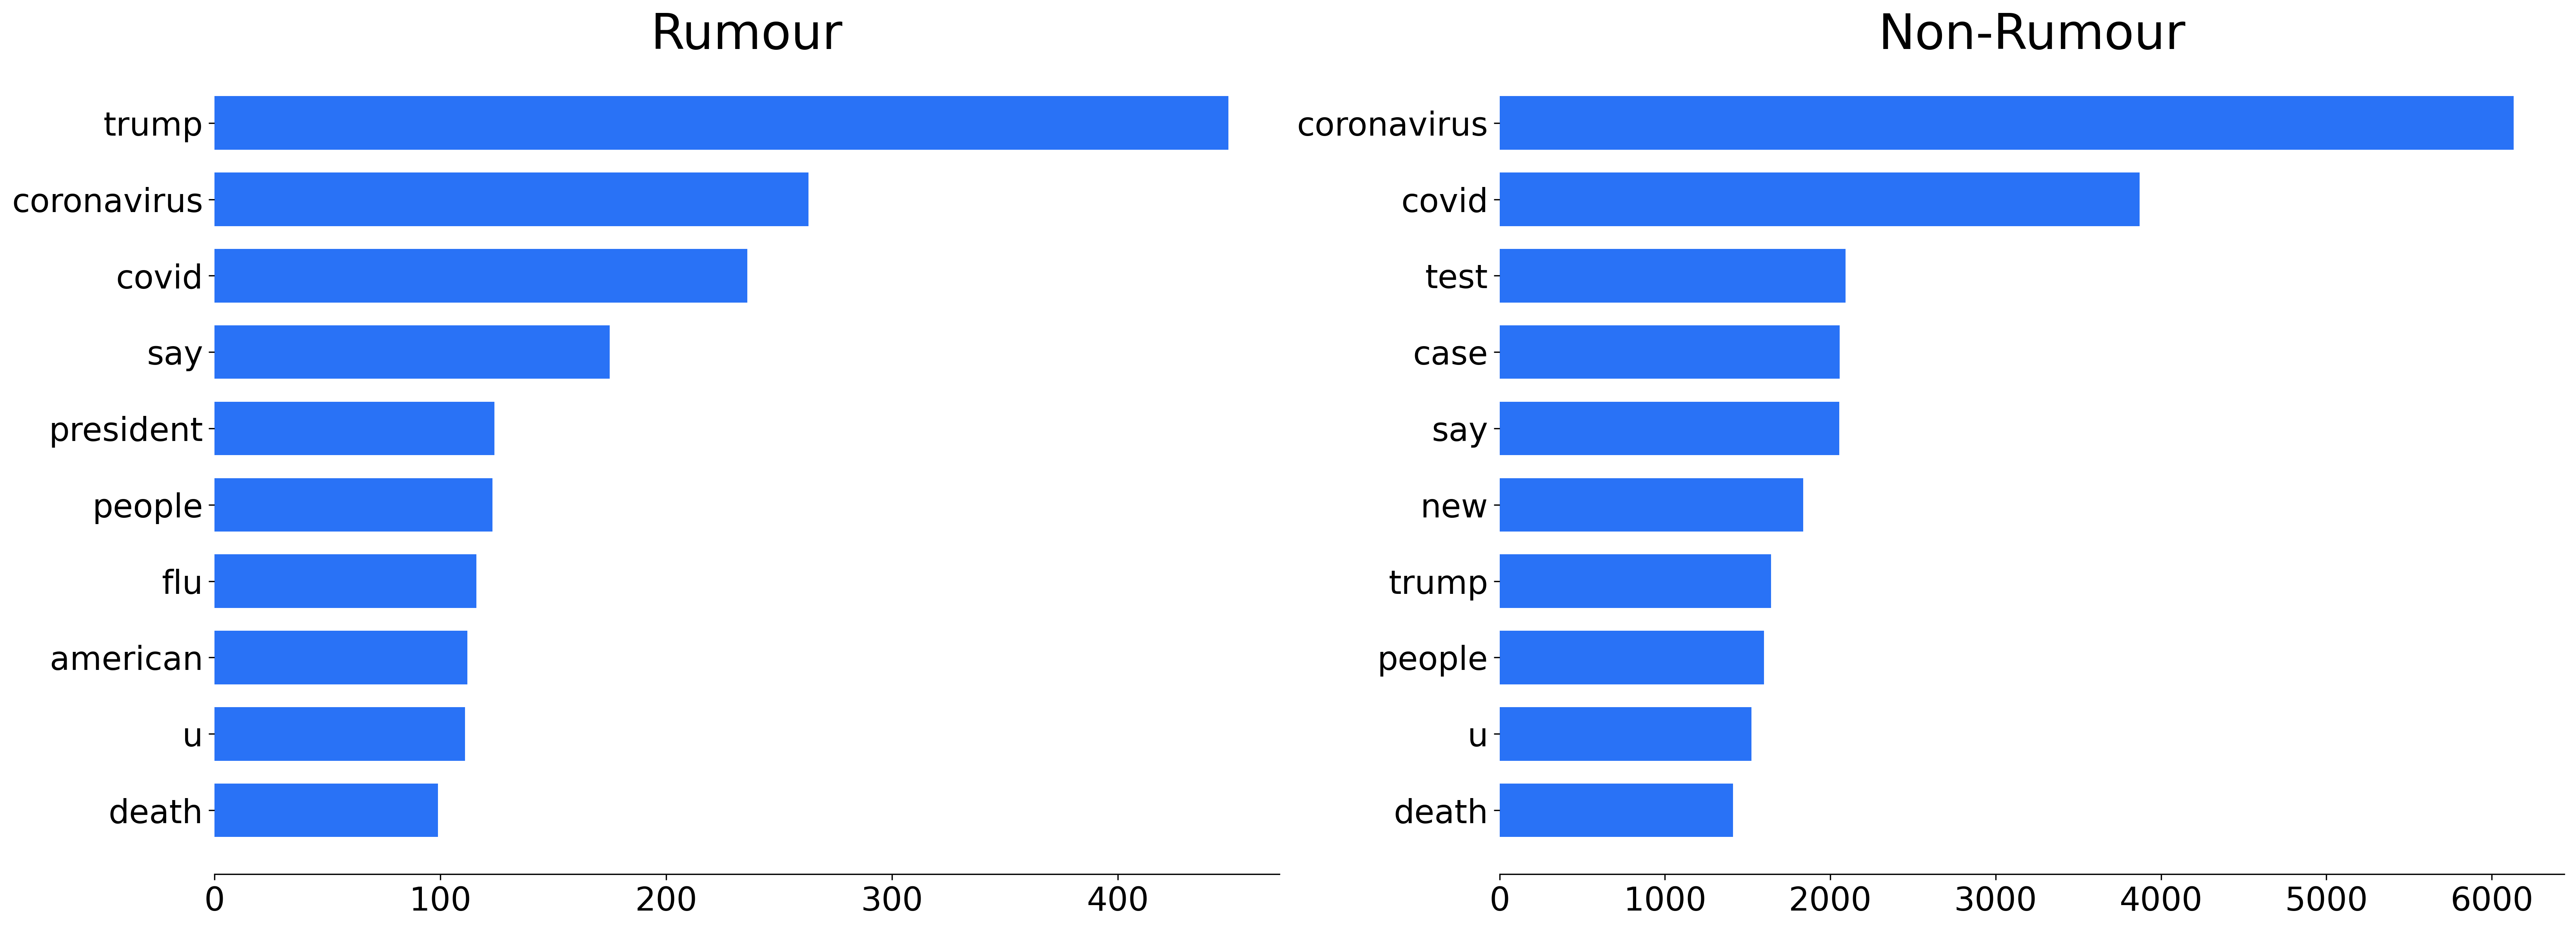

In [15]:
def draw_common_words():
    rumour_x_data = [i[0] for i in rumour_text_rank]
    rumour_y_data = [i[1] for i in rumour_text_rank]
    non_rumour_x_data = [i[0] for i in non_rumour_text_rank]
    non_rumour_y_data = [i[1] for i in non_rumour_text_rank]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8), dpi=300)

    axes[0].barh(rumour_x_data, rumour_y_data, height=0.7, color="#2972F6")
    axes[0].set_title("Rumour", fontdict={"fontsize": 30})
    axes[0].invert_yaxis()
    axes[0].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[0].spines[i].set_visible(False)

    axes[1].barh(non_rumour_x_data, non_rumour_y_data, height=0.7, color="#2972F6")
    axes[1].set_title("Non-Rumour", fontdict={"fontsize": 30})
    axes[1].invert_yaxis()
    axes[1].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[1].spines[i].set_visible(False)

    plt.tight_layout()
    plt.show()

draw_common_words()

## 4. Hashtag Analysis

In [7]:
rumour_hashtag = [lines["hashtag"] for lines in rumour_list if len(lines["hashtag"]) > 0]
non_rumour_hashtag= [lines["hashtag"] for lines in non_rumour_list if len(lines["hashtag"]) > 0]

def count_common_hashtags(hashtag_list):
    common_hashtag = {}
    for hashtags in hashtag_list:
        for hashtag in hashtags:
            # hashtag = hashtag[1:]
            if hashtag in common_hashtag:
                common_hashtag[hashtag] += 1
            else:
                common_hashtag[hashtag] = 1
    sorted_common_words = sorted(common_hashtag.items(), key=lambda x: x[1], reverse=True)[:15]
    return sorted_common_words

rumour_hashtag_rank = count_common_hashtags(rumour_hashtag)
non_rumour_hashtag_rank = count_common_hashtags(non_rumour_hashtag)

/var/folders/yy/3xdbk_rd7zjcs4y3m259qjt00000gn/T/ipykernel_24143/3142466253.py:23: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
/Users/z/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


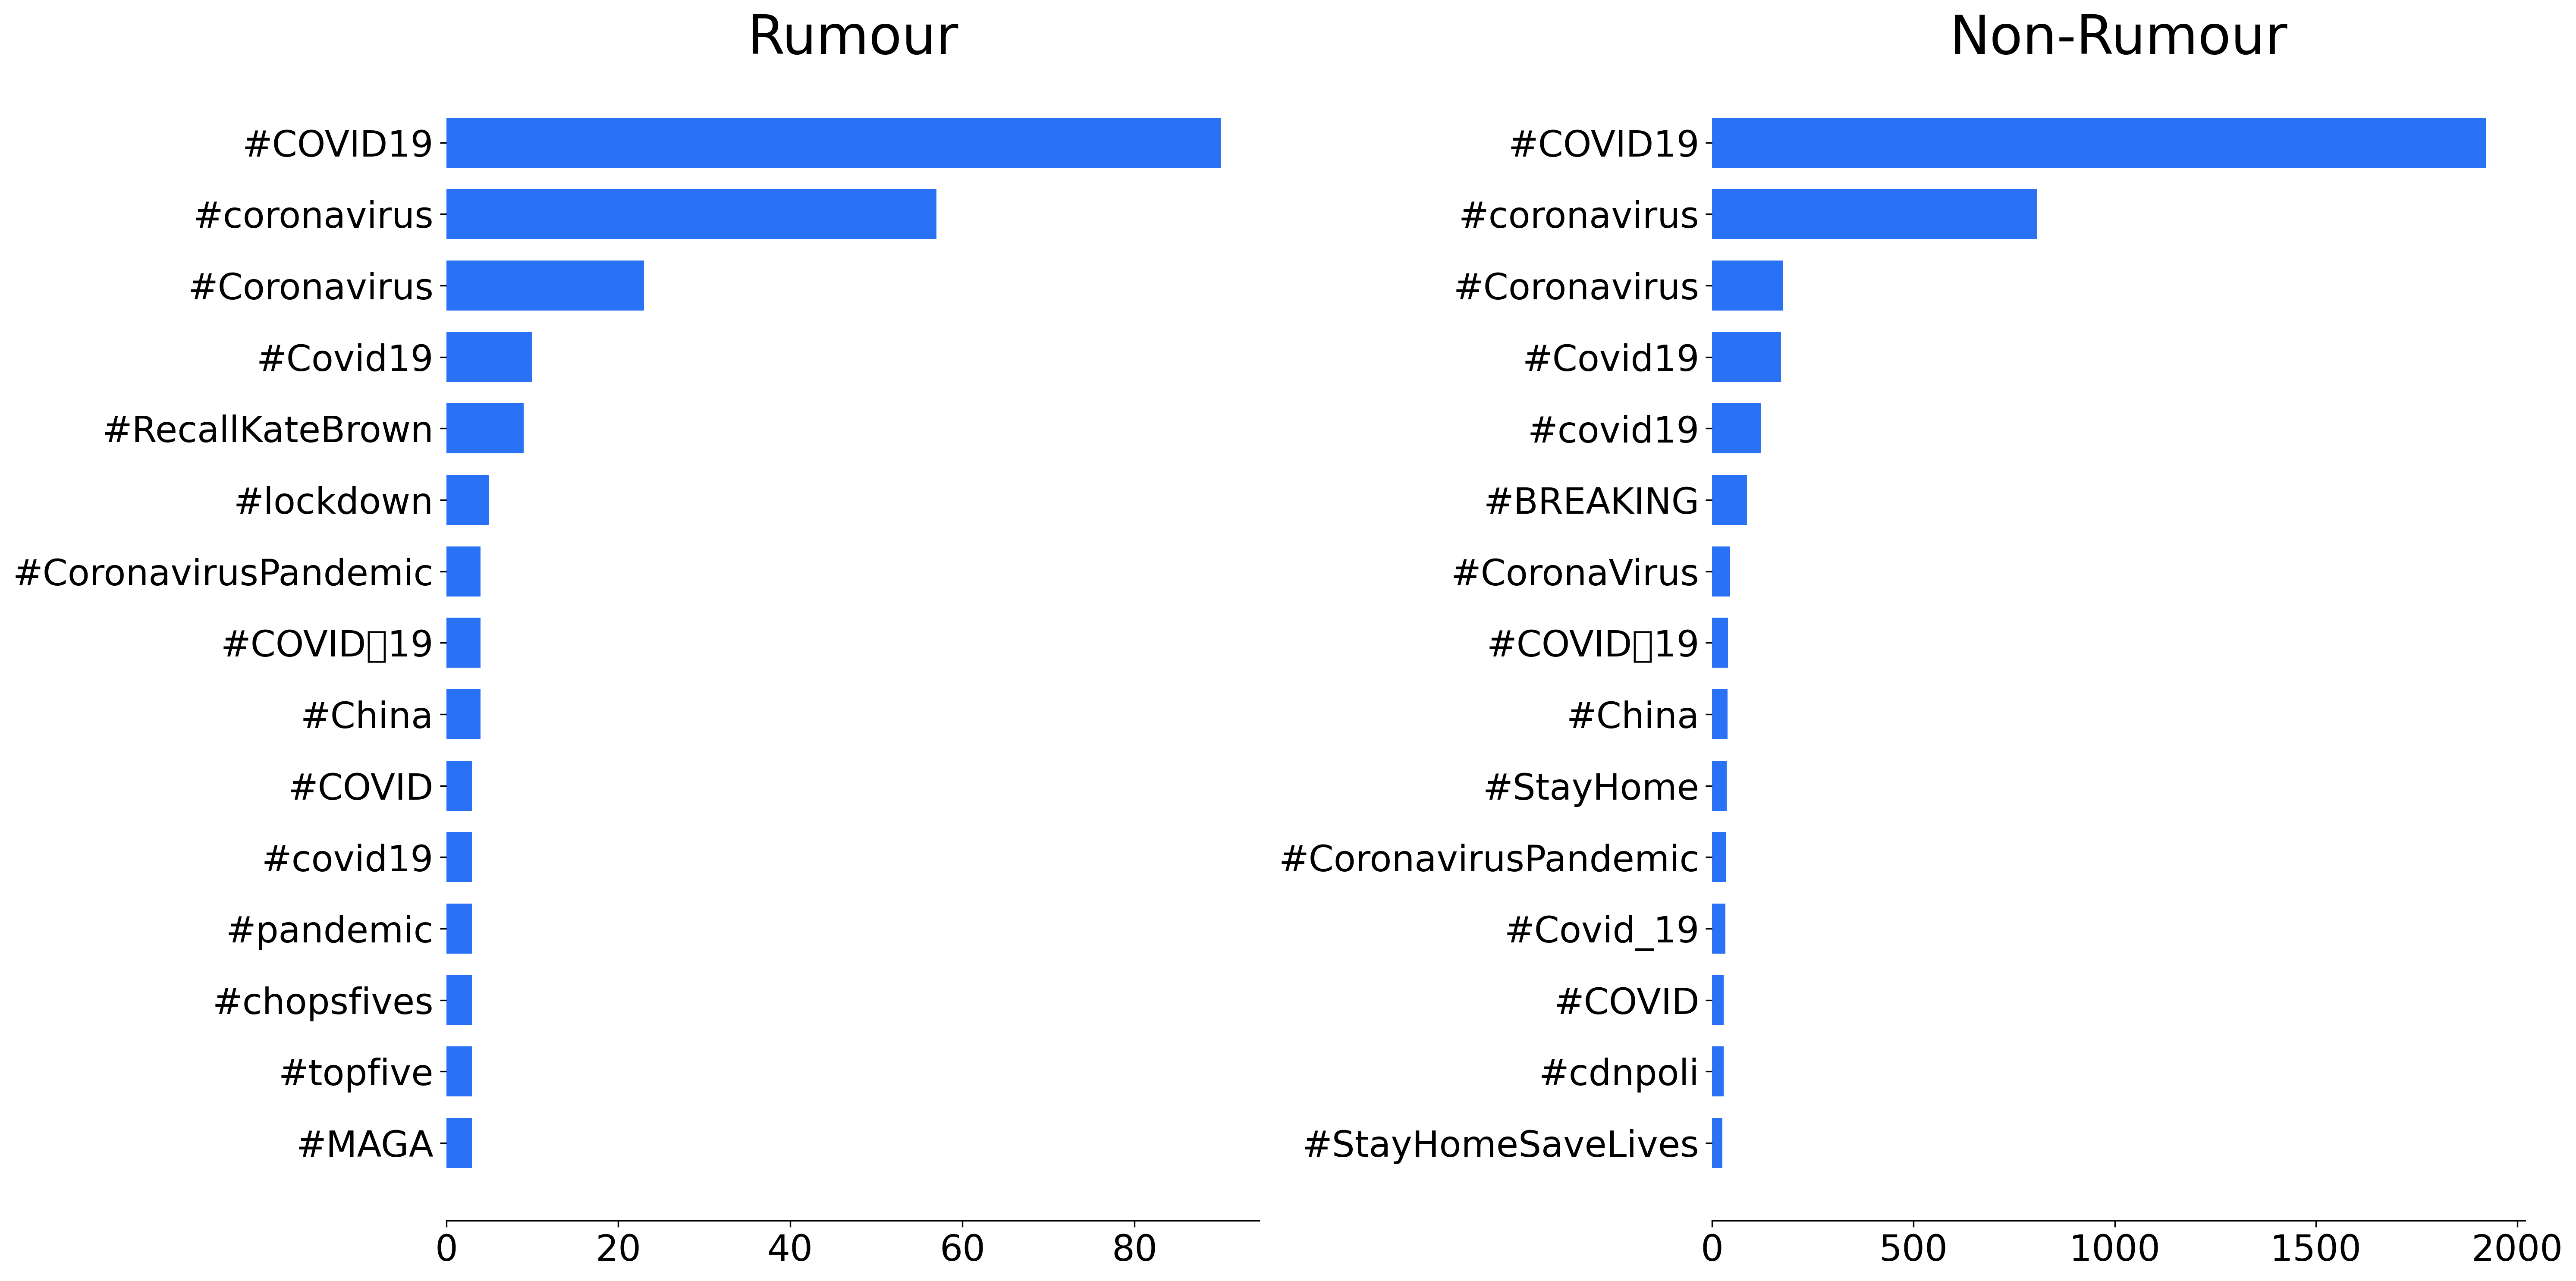

In [8]:
def draw_common_hashtags():
    rumour_x_data = [i[0] for i in rumour_hashtag_rank]
    rumour_y_data = [i[1] for i in rumour_hashtag_rank]
    non_rumour_x_data = [i[0] for i in non_rumour_hashtag_rank]
    non_rumour_y_data = [i[1] for i in non_rumour_hashtag_rank]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=300)

    axes[0].barh(rumour_x_data, rumour_y_data, height=0.7, color="#2972F6")
    axes[0].set_title("Rumour", fontdict={"fontsize": 30})
    axes[0].invert_yaxis()
    axes[0].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[0].spines[i].set_visible(False)

    axes[1].barh(non_rumour_x_data, non_rumour_y_data, height=0.7, color="#2972F6")
    axes[1].set_title("Non-Rumour", fontdict={"fontsize": 30})
    axes[1].invert_yaxis()
    axes[1].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[1].spines[i].set_visible(False)

    plt.tight_layout()
    plt.show()

draw_common_hashtags()

## 5. Sentiment Analysis

In [9]:
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def sentiment_analysis(text_list):
    positive_score = 0
    negative_score = 0
    neutral_score = 0
    for text in text_list:
        score = sia.polarity_scores(text)
        positive_score += score["pos"]
        negative_score += score["neg"]
        neutral_score += score["neu"]
    return positive_score, negative_score, neutral_score

rumour_sentiment = sentiment_analysis(rumour_text)
non_rumour_sentiment = sentiment_analysis(non_rumour_text)

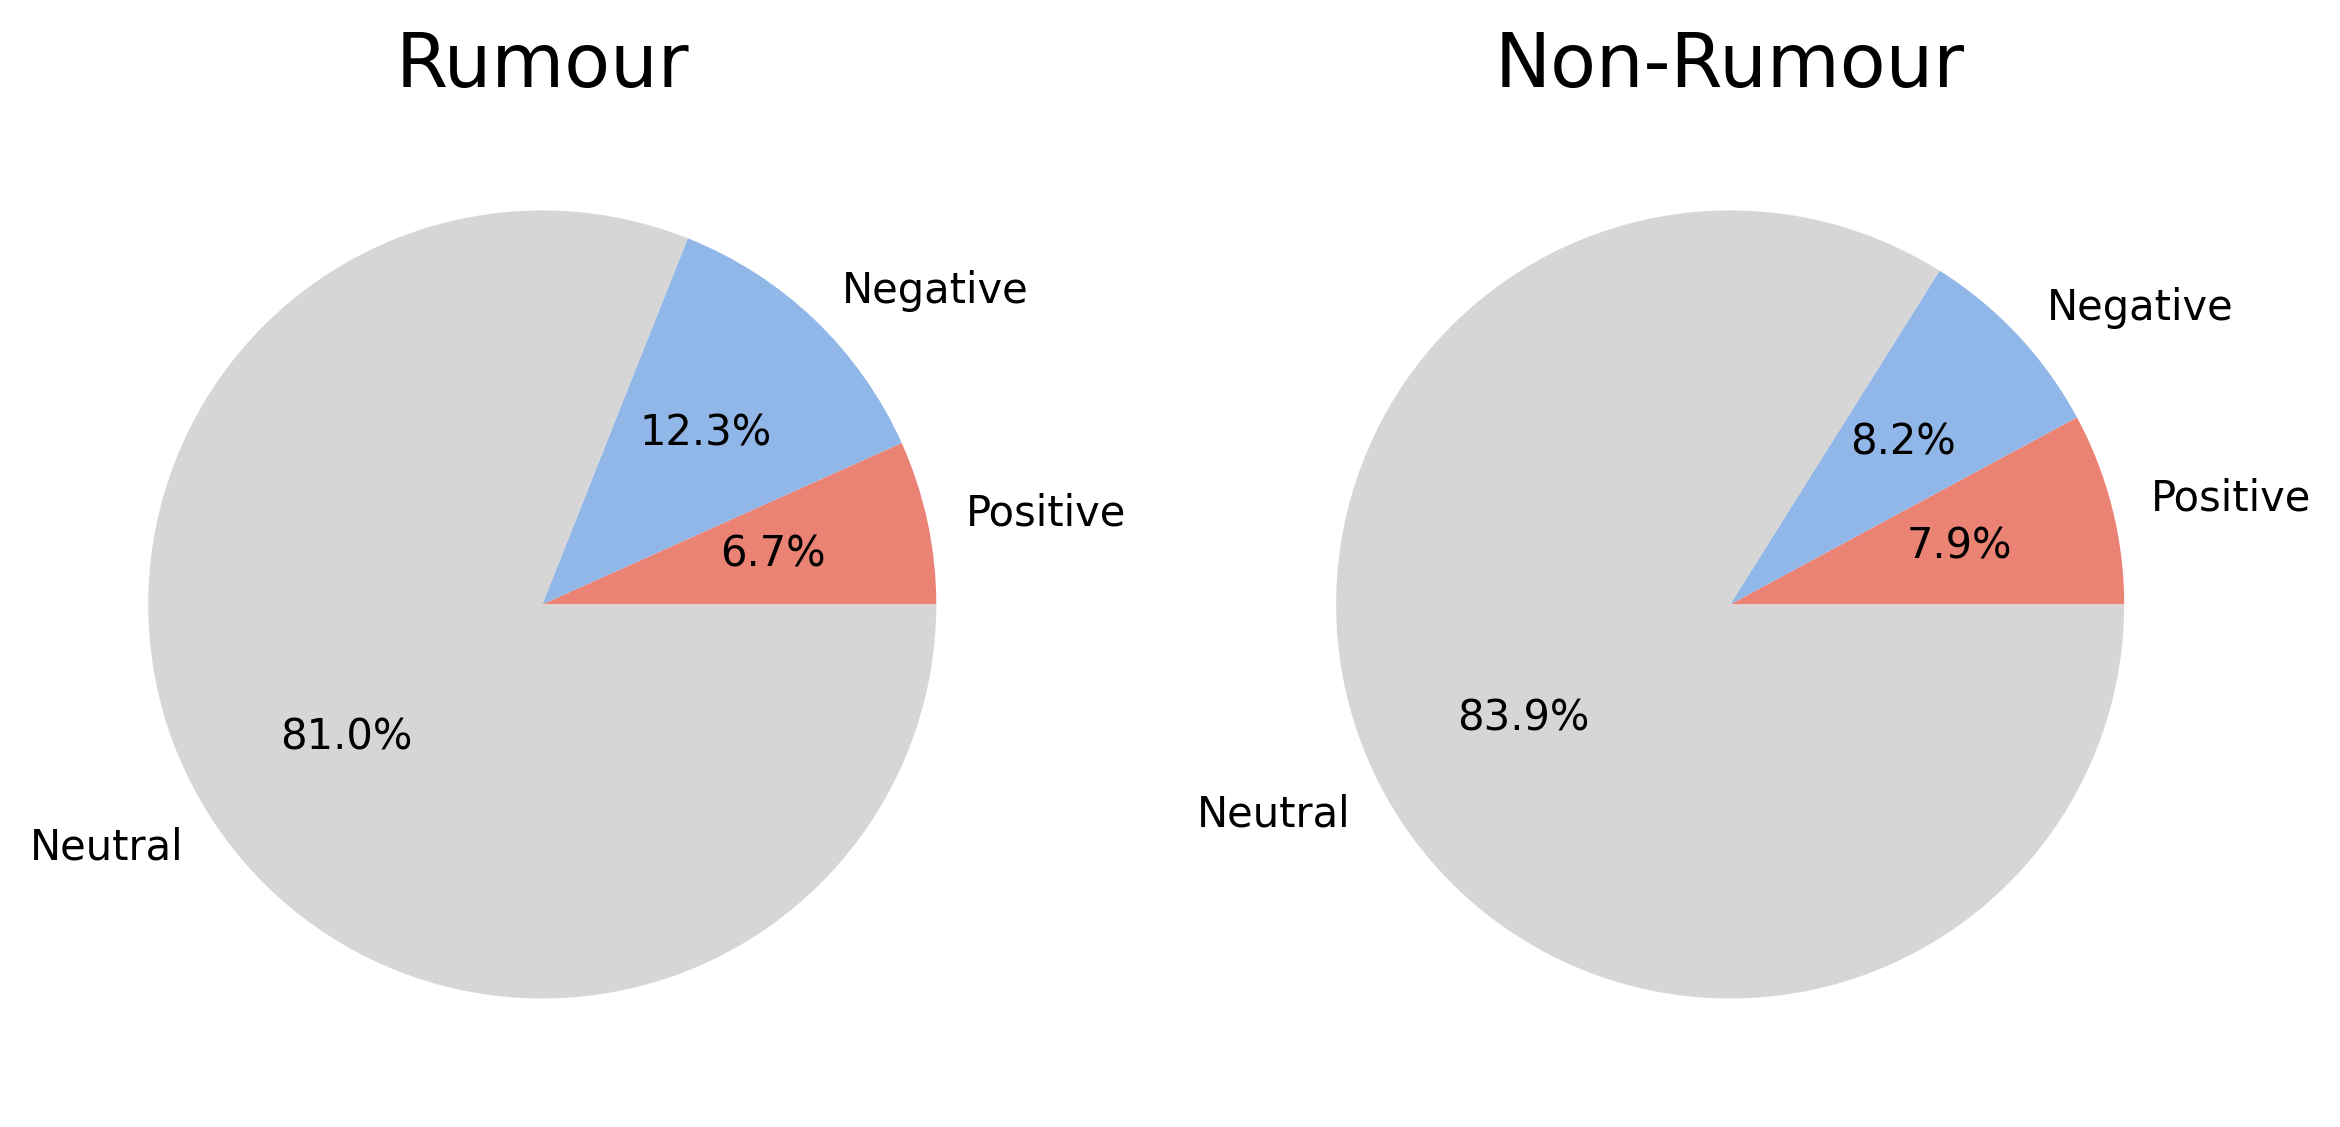

In [10]:
def draw_sentiment_analysis():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=300)
    colors = ["#EB8375", "#91B6E8", "#D6D6D6"]

    axes[0].pie([rumour_sentiment[0], rumour_sentiment[1], rumour_sentiment[2]], labels=["Positive", "Negative", "Neutral"], autopct="%1.1f%%", colors=colors)
    axes[0].set_title("Rumour", fontdict={"fontsize": 18})
    axes[0].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[0].spines[i].set_visible(False)

    axes[1].pie([non_rumour_sentiment[0], non_rumour_sentiment[1], non_rumour_sentiment[2]], labels=["Positive", "Negative", "Neutral"], autopct="%1.1f%%", colors=colors)
    axes[1].set_title("Non-Rumour", fontdict={"fontsize": 18})
    axes[1].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[1].spines[i].set_visible(False)

    plt.tight_layout()
    plt.show()

draw_sentiment_analysis()

## 6. User Engagement

In [11]:
def count_user_characteristics(tweet_list):
    total_count = {"retweet": 0, "reply": 0, "like": 0, "quote": 0}
    for data in tweet_list:
        total_count["retweet"] += data["retweet_count"]
        total_count["reply"] += data["reply_count"]
        total_count["like"] += data["like_count"]
        total_count["quote"] += data["quote_count"]
    return total_count

rumour_user_char = count_user_characteristics(rumour_list)
non_rumour_user_char = count_user_characteristics(non_rumour_list)

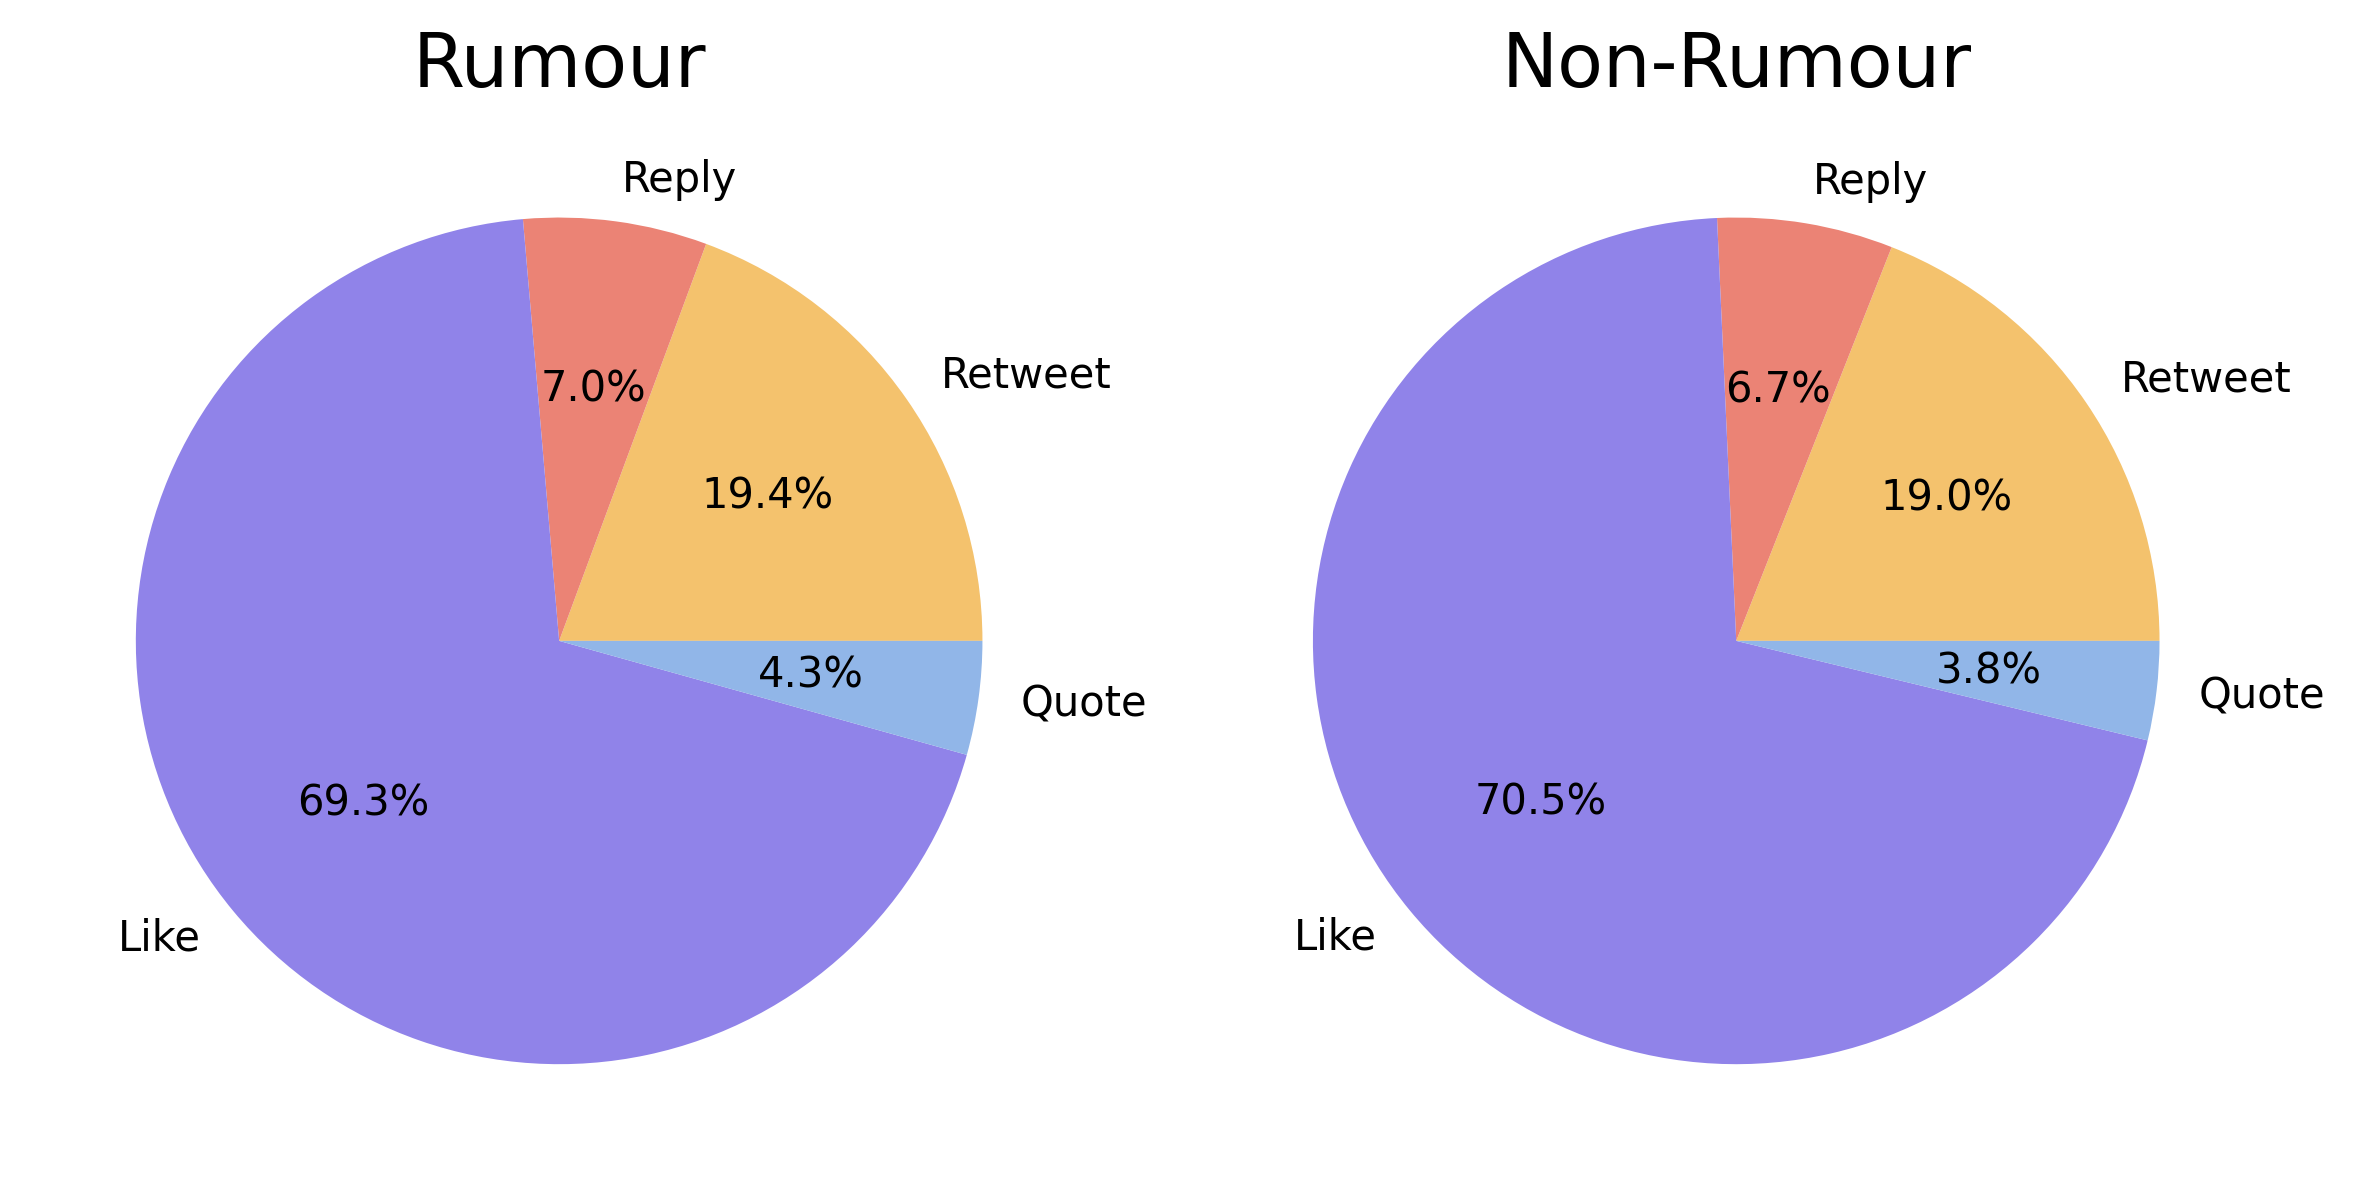

In [12]:
def draw_user_characteristics():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=300)
    colors = ["#F4C26D", "#EB8375", "#9083E9", "#91B6E8"]

    axes[0].pie([rumour_user_char["retweet"], rumour_user_char["reply"], rumour_user_char["like"], rumour_user_char["quote"]], labels=["Retweet", "Reply", "Like", "Quote"], autopct="%1.1f%%", colors=colors)
    axes[0].set_title("Rumour", fontdict={"fontsize": 18})
    axes[0].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[0].spines[i].set_visible(False)

    axes[1].pie([non_rumour_user_char["retweet"], non_rumour_user_char["reply"], non_rumour_user_char["like"], non_rumour_user_char["quote"]], labels=["Retweet", "Reply", "Like", "Quote"], autopct="%1.1f%%", colors=colors)
    axes[1].set_title("Non-Rumour", fontdict={"fontsize": 18})
    axes[1].tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        axes[1].spines[i].set_visible(False)

    plt.tight_layout()
    plt.show()

draw_user_characteristics()